In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import pandas as pd
import salem
from scipy.stats import ttest_ind
import matplotlib.colors as mcolors

# Load ensemble avg and members

In [2]:
# Step 1: load ensemble members and average
arise_mean = xr.open_dataset('/glade/campaign/univ/urtg0006/Brendan/yield_landuse/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.AVG.clm2.h1.yield.203501-207012.nc')
ssp_mean = xr.open_dataset('/glade/campaign/univ/urtg0006/Brendan/yield_landuse/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.AVG.clm2.h1.yield.203501-206912.nc')

mask = salem.read_shapefile('/glade/u/home/ninag/shapefiles/IND_adm0.shp') #load India mask

# Generate a range of dates from 2035-01-01 to 2069-12-31
date_range = pd.date_range(start='2035-01-01', end='2069-01-01', freq='AS')
# Update the 'time' coordinate in the dataset with the shifted dates
arise_mean['time'], ssp_mean['time'] = date_range, date_range

# Select only rice and wheat over India
india_region_ds = arise_mean.sel(crops=[3.0, 9.0]).sel(lon=slice(65, 100), lat=slice(5, 37))
india_region_ssp = ssp_mean.sel(crops=[3.0, 9.0]).sel(lon=slice(65, 100), lat=slice(5, 37))

# Apply the mask over India
india_region_ds_masked = india_region_ds.salem.roi(shape=mask, all_touched=False)
india_region_ssp_masked = india_region_ssp.salem.roi(shape=mask, all_touched=False)

In [3]:
reference = arise_mean

wheatmask = xr.open_mfdataset('shapefiles/Deepak_files/Wheat*.nc', combine='nested', concat_dim='time').Data.squeeze()
wheatmask = wheatmask.sel(latitude=slice(37,5), longitude=slice(65,100)).where(wheatmask > 0.1).count('time')
wheatmask = wheatmask.rename({"latitude": "lat", "longitude": "lon"})
regridded_wheatmask = wheatmask.interp_like(reference)

ricemask = xr.open_mfdataset('shapefiles/Deepak_files/Rice*.nc', combine='nested', concat_dim='time').Data.squeeze()
ricemask = ricemask.sel(latitude=slice(37,5), longitude=slice(65,100)).where(ricemask > 0.1).count('time')
ricemask = ricemask.rename({"latitude": "lat", "longitude": "lon"})
regridded_ricemask = ricemask.interp_like(reference)

In [4]:
def significance(data1, data2):
    # Initialize an empty array to store the p-values
    p_values = xr.DataArray(np.nan, dims=('lat', 'lon'), coords={'lat': data1.lat, 'lon': data1.lon})
    
    for lat in data1.lat:
        for lon in data1.lon:
            _, p_val = ttest_ind(data1.sel(lat=lat, lon=lon),
                                 data2.sel(lat=lat, lon=lon),
                                 equal_var=True)
            # Store the p-value
            p_values.loc[lat, lon] = p_val
    return p_values

In [5]:
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))),)
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))),)
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [
            normalized_min,
            normalized_mid,
            normalized_max,
        ]
        return np.ma.masked_array(np.interp(value, x, y))

## Yield Results

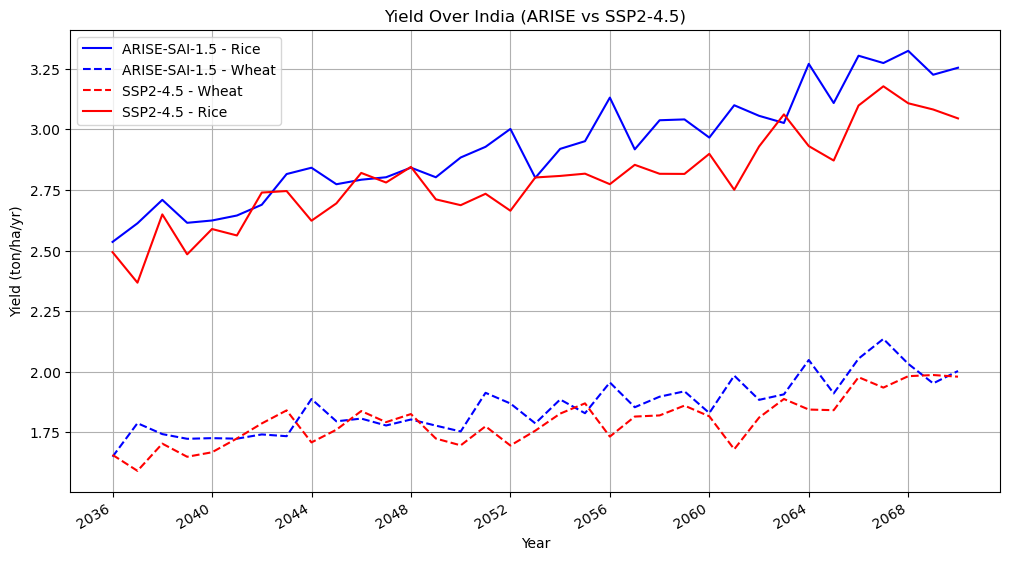

In [10]:
# Step 3: Apply the mask over India
mask = salem.read_shapefile('/glade/u/home/ninag/shapefiles/IND_adm0.shp')
india_region_ds_masked = india_region_ds.salem.roi(shape=mask, all_touched=True)
india_region_ssp_masked = india_region_ssp.salem.roi(shape=mask, all_touched=True)

# Step 4: Compute the average over the India grid
india_grid_average_ds = india_region_ds_masked.mean(dim=['lon', 'lat'])
india_grid_average_ssp = india_region_ssp_masked.mean(dim=['lon', 'lat'])

# Step 5: Plot the time series
plt.figure(figsize=(12, 6))

# Plot ARISE yield
india_grid_average_ds['yield'].sel(crops=3).plot(label='ARISE-SAI-1.5 - Rice', color='blue')
india_grid_average_ds['yield'].sel(crops=9).plot(label='ARISE-SAI-1.5 - Wheat', color='blue', ls='--')

# Plot SSP yield
india_grid_average_ssp['yield'].sel(crops=9).plot(label='SSP2-4.5 - Wheat', color='red', ls='--')
india_grid_average_ssp['yield'].sel(crops=3).plot(label='SSP2-4.5 - Rice', color='red')


# Set title and labels
plt.title('Yield Over India (ARISE vs SSP2-4.5)')
plt.xlabel('Year')
plt.ylabel('Yield (ton/ha/yr)')
plt.legend()
plt.grid(True)
plt.show()


## Production Results

In [6]:
# Ensemble Average
# Multiply yield by area to get production
india_region_ds_masked['production'] = india_region_ds_masked['yield'] * india_region_ds_masked['area']
india_region_ssp_masked['production'] = india_region_ssp_masked['yield'] * india_region_ssp_masked['area']

# Compute the average over the India grid
india_avg_arise_rice = india_region_ds_masked['production'].sel(crops=3).where(regridded_ricemask >= 5).sum(dim=['lon', 'lat'])
india_avg_arise_wheat = india_region_ds_masked['production'].sel(crops=9).where(regridded_wheatmask >= 5).sum(dim=['lon', 'lat'])
india_avg_ssp_rice = india_region_ssp_masked['production'].sel(crops=3).where(regridded_ricemask >= 5).sum(dim=['lon', 'lat'])
india_avg_ssp_wheat = india_region_ssp_masked['production'].sel(crops=9).where(regridded_wheatmask >= 5).sum(dim=['lon', 'lat'])

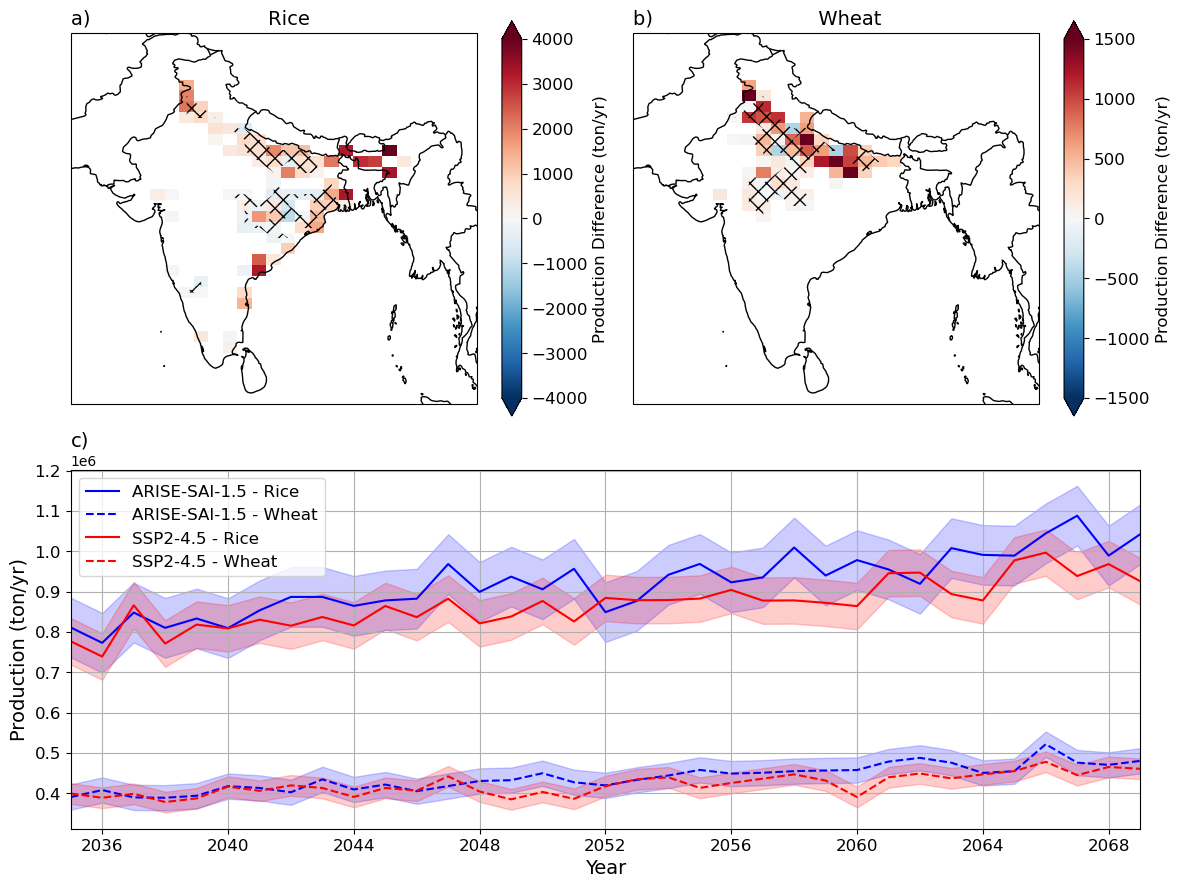

In [15]:
# Compute the difference between the two datasets for each crop
difference_rice = (india_region_ds_masked.sel(crops=3)['production'] -
                   india_region_ssp_masked.sel(crops=3)['production']).sel(time=slice('2050', '2069')).where(regridded_ricemask >= 5)

difference_wheat = (india_region_ds_masked.sel(crops=9)['production'] -
                    india_region_ssp_masked.sel(crops=9)['production']).sel(time=slice('2050', '2069')).where(regridded_wheatmask >= 5)

rice_pvalues = significance(india_region_ds_masked['production'].sel(crops=3).sel(time=slice('2050', '2069')),
                            india_region_ssp_masked['production'].sel(crops=3).sel(time=slice('2050', '2069'))).where(regridded_ricemask >= 5)

wheat_pvalues = significance(india_region_ds_masked['production'].sel(crops=9).sel(time=slice('2050', '2069')),
                            india_region_ssp_masked['production'].sel(crops=9).sel(time=slice('2050', '2069'))).where(regridded_wheatmask >= 5)


# Create GridSpec layout
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1.1, 1])

# Plot maps
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
plot_rice = difference_rice.mean(dim='time').plot(ax=ax1,
                                                  cmap='RdBu_r',
                                                  transform=ccrs.PlateCarree(),
                                                  add_colorbar=False,
                                                  add_labels=False,
                                                  vmin=-4000,
                                                  vmax=4000
                                                 )
# hatch any statistical insignificance (above 5%)
sig = rice_pvalues.where(rice_pvalues > 0.05)
sig.plot.contourf(ax=ax1, hatches=['xx'], colors='none', extend='neither', add_colorbar=False, add_labels=False)

# ax1.set_title("Difference in Rainfed Rice Production (ARISE-SAI-1.5 - SSP2-4.5)\n 2050-2069")
ax1.set_title("a)                             Rice", fontsize=14, loc='left')
ax1.add_feature(cfeature.COASTLINE, linewidth=1)
ax1.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
ax1.set_extent([65, 100, 5, 37], crs=ccrs.PlateCarree())
cbar1 = plt.colorbar(plot_rice, ax=ax1, label='Production Difference (ton/yr)', extend='both', pad=0.05)
cbar1.ax.tick_params(labelsize=12)  # Increase colorbar tick font size
cbar1.set_label('Production Difference (ton/yr)', fontsize=12)

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
plot_wheat = difference_wheat.mean(dim='time').plot(ax=ax2,
                                                    cmap='RdBu_r',
                                                    transform=ccrs.PlateCarree(),
                                                    add_colorbar=False,
                                                    add_labels=False,
                                                    vmax=1500,
                                                    vmin=-1500
                                                   )
# hatch any statistical insignificance (above 5%)
sig = wheat_pvalues.where(wheat_pvalues > 0.05)
sig.plot.contourf(ax=ax2, hatches=['xx'], colors='none', extend='neither', add_colorbar=False, add_labels=False)

ax2.set_title("b)                           Wheat", fontsize=14, loc='left')
# ax2.set_title("Difference in Rainfed Wheat Production (ARISE-SAI-1.5 - SSP2-4.5)\n 2050-2069")
ax2.add_feature(cfeature.COASTLINE, linewidth=1)
ax2.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
ax2.set_extent([65, 100, 5, 37], crs=ccrs.PlateCarree())
cbar2 = plt.colorbar(plot_wheat, ax=ax2, label='Production Difference (ton/yr)', extend='both', pad=0.05)
cbar2.ax.tick_params(labelsize=12)  # Increase colorbar tick font size
cbar2.set_label('Production Difference (ton/yr)', fontsize=12)



# Plot time series
ax3 = fig.add_subplot(gs[1, :])

# Plot ARISE production
ax3.plot(india_avg_arise_rice.time, india_avg_arise_rice, label='ARISE-SAI-1.5 - Rice', color='blue')
ax3.plot(india_avg_arise_wheat.time, india_avg_arise_wheat, label='ARISE-SAI-1.5 - Wheat', color='blue', ls='--')

# Plot SSP production
ax3.plot(india_avg_ssp_rice.time, india_avg_ssp_rice, label='SSP2-4.5 - Rice', color='red')
ax3.plot(india_avg_ssp_wheat.time, india_avg_ssp_wheat, label='SSP2-4.5 - Wheat', color='red', ls='--')

# Plot range for ARISE production
ax3.fill_between(india_avg_arise_rice.time,
                 india_avg_arise_rice - india_avg_arise_rice.std(),
                 india_avg_arise_rice + india_avg_arise_rice.std(), color='blue', alpha=0.2)
ax3.fill_between(india_avg_arise_wheat.time,
                 india_avg_arise_wheat - india_avg_arise_wheat.std(),
                 india_avg_arise_wheat + india_avg_arise_wheat.std(), color='blue', alpha=0.2)

# Plot range for SSP production
ax3.fill_between(india_avg_ssp_rice.time,
                 india_avg_ssp_rice - india_avg_ssp_rice.std(),
                 india_avg_ssp_rice + india_avg_ssp_rice.std(), color='red', alpha=0.2)
ax3.fill_between(india_avg_ssp_wheat.time,
                 india_avg_ssp_wheat - india_avg_ssp_wheat.std(),
                 india_avg_ssp_wheat + india_avg_ssp_wheat.std(), color='red', alpha=0.2)

# Set title and labels
ax3.set_title('c)', fontsize=14, loc='left')
# ax3.set_title('Total Rainfed Rice and Wheat Production in India (ARISE-SAI-1.5 vs SSP2-4.5)')
ax3.set_xlabel('Year', fontsize=14)
ax3.set_ylabel('Production (ton/yr)', fontsize=14)
ax3.tick_params(axis='both', labelsize=12)  # Increase tick label font size
ax3.legend(loc='upper left', fontsize=12)
ax3.set_xlim(india_avg_arise_rice['time'].min(), india_avg_arise_rice['time'].max())
ax3.grid(True)

plt.tight_layout()

# Irrigated v. Rainfed

In [7]:
# Select only rainfed rice and wheat over India

india_region_ds_rainfed = arise_mean.sel(crops=[4.0, 10.0]).sel(lon=slice(65, 100), lat=slice(5, 37))
india_region_ssp_rainfed = ssp_mean.sel(crops=[4.0, 10.0]).sel(lon=slice(65, 100), lat=slice(5, 37))

# Apply the mask over India
# Ensemble average
india_region_ds_masked_rain = india_region_ds_rainfed.salem.roi(shape=mask, all_touched=False)
india_region_ssp_masked_rain = india_region_ssp_rainfed.salem.roi(shape=mask, all_touched=False)

In [8]:
# Ensemble Average

# SMultiply yield by area to get production
india_region_ds_masked_rain['production'] = india_region_ds_masked_rain['yield'] * india_region_ds_masked_rain['area']
india_region_ssp_masked_rain['production'] = india_region_ssp_masked_rain['yield'] * india_region_ssp_masked_rain['area']

# Step 8: Compute the average over the India grid
india_avg_arise_rice_rain = india_region_ds_masked_rain['production'].sel(crops=4).where(regridded_ricemask >= 5).sum(dim=['lon', 'lat'])
india_avg_arise_wheat_rain = india_region_ds_masked_rain['production'].sel(crops=10).where(regridded_wheatmask >= 5).sum(dim=['lon', 'lat'])
india_avg_ssp_rice_rain = india_region_ssp_masked_rain['production'].sel(crops=4).where(regridded_ricemask >= 5).sum(dim=['lon', 'lat'])
india_avg_ssp_wheat_rain = india_region_ssp_masked_rain['production'].sel(crops=10).where(regridded_wheatmask >= 5).sum(dim=['lon', 'lat'])

In [9]:
# Compute the difference between the two datasets for each crop
difference_rice = (india_region_ds_masked_rain.sel(crops=4)['production'] -
                   india_region_ssp_masked_rain.sel(crops=4)['production']).sel(time=slice('2050', '2069')).where(regridded_ricemask >= 5)

difference_wheat = (india_region_ds_masked_rain.sel(crops=10)['production'] -
                    india_region_ssp_masked_rain.sel(crops=10)['production']).sel(time=slice('2050', '2069')).where(regridded_wheatmask >= 5)

rice_pvalues = significance(india_region_ds_masked_rain['production'].sel(crops=4).sel(time=slice('2050', '2069')),
                            india_region_ssp_masked_rain['production'].sel(crops=4).sel(time=slice('2050', '2069'))).where(regridded_ricemask >= 5)

wheat_pvalues = significance(india_region_ds_masked_rain['production'].sel(crops=10).sel(time=slice('2050', '2069')),
                            india_region_ssp_masked_rain['production'].sel(crops=10).sel(time=slice('2050', '2069'))).where(regridded_wheatmask >= 5)

In [10]:
# Select only irrigated rice and wheat over India
india_region_ds_irrigated = arise_mean.sel(crops=[5.0, 11.0]).sel(lon=slice(65, 100), lat=slice(5, 37))
india_region_ssp_irrigated = ssp_mean.sel(crops=[5.0, 11.0]).sel(lon=slice(65, 100), lat=slice(5, 37))

# Apply the mask over India
# Ensemble average
india_region_ds_masked_irrigated = india_region_ds_irrigated.salem.roi(shape=mask, all_touched=False)
india_region_ssp_masked_irrigated = india_region_ssp_irrigated.salem.roi(shape=mask, all_touched=False)

In [11]:
# Ensemble average
india_region_ds_masked_irrigated['production'] = india_region_ds_masked_irrigated['yield'] * india_region_ds_masked_irrigated['area']
india_region_ssp_masked_irrigated['production'] = india_region_ssp_masked_irrigated['yield'] * india_region_ssp_masked_irrigated['area']

# Compute the difference between the two datasets for each crop
difference_rice_irr = (india_region_ds_masked_irrigated.sel(crops=5)['production'] -
                       india_region_ssp_masked_irrigated.sel(crops=5)['production']).sel(time=slice('2050', '2069')).where(regridded_ricemask >= 5)

difference_wheat_irr = (india_region_ds_masked_irrigated.sel(crops=11)['production'] -
                        india_region_ssp_masked_irrigated.sel(crops=11)['production']).sel(time=slice('2050', '2069')).where(regridded_wheatmask >= 5)

rice_irr_pvalues = significance(india_region_ds_masked_irrigated['production'].sel(crops=5).sel(time=slice('2050', '2069')),
                                india_region_ssp_masked_irrigated['production'].sel(crops=5).sel(time=slice('2050', '2069'))).where(regridded_ricemask >= 5)

wheat_irr_pvalues = significance(india_region_ds_masked_irrigated['production'].sel(crops=11).sel(time=slice('2050', '2069')),
                                 india_region_ssp_masked_irrigated['production'].sel(crops=11).sel(time=slice('2050', '2069'))).where(regridded_wheatmask >= 5)

/glade/derecho/scratch/ninag/tmp/ipykernel_23666/2793829660.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.97, 1])  # Adjust the tight_layout to consider the colorbar


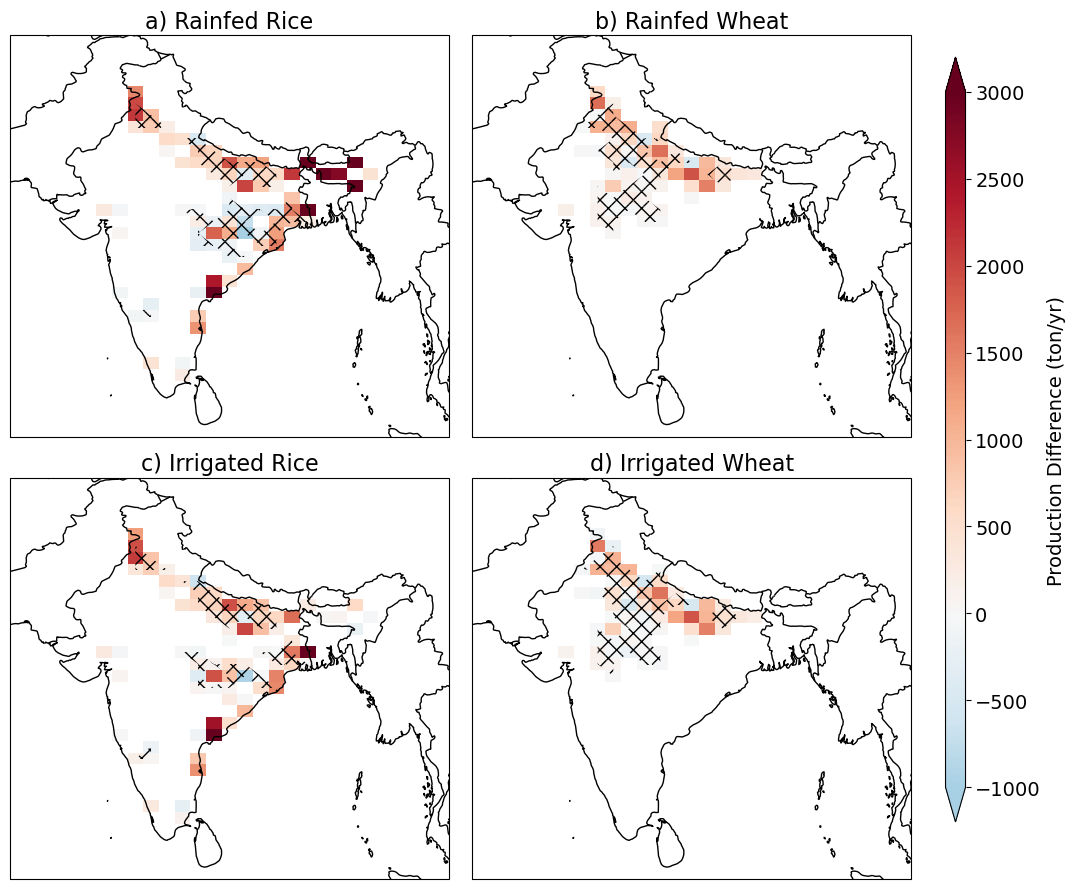

In [16]:
titles = ['a) Rainfed Rice', 'b) Rainfed Wheat', 'c) Irrigated Rice', 'd) Irrigated Wheat']
pvalues = [rice_pvalues, wheat_pvalues, rice_irr_pvalues, wheat_irr_pvalues]
difference = [difference_rice, difference_wheat, difference_rice_irr, difference_wheat_irr]

fig, axes = plt.subplots(2, 2, figsize=(10, 9), subplot_kw={'projection': ccrs.PlateCarree()})
plots = []
norm = MidpointNormalize(vmin=-1000, vmax=3000, midpoint=0)

for i, ax in enumerate(axes.flatten()):
    plot = difference[i].mean(dim='time').plot(ax=ax,
                                               cmap='RdBu_r',
                                               norm=norm,
                                               transform=ccrs.PlateCarree(),
                                               add_colorbar=False,
                                               )
    plots.append(plot)
    
    # Hatch any statistical insignificance (above 5%)
    sig = pvalues[i].where(pvalues[i] > 0.05)
    sig.plot.contourf(ax=ax, hatches=['xx'], colors='none', extend='neither', add_colorbar=False)
    
    ax.set_title(titles[i], fontsize=16, loc='center')
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([65, 100, 5, 37], crs=ccrs.PlateCarree())

# Adjust the layout to make space for the colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.08, 0.02, 0.85])  # [left, bottom, width, height]
cbar = fig.colorbar(plots[0], cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick font size
cbar.set_label('Production Difference (ton/yr)', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.97, 1])  # Adjust the tight_layout to consider the colorbar


In [12]:
# Normalize results based on total production in that region under SSP245
percent_rice_irr = (difference_rice_irr.mean(dim='time') / india_region_ssp_masked_irrigated.sel(crops=5)['production'].sel(time=slice('2050', '2069')).mean(dim='time')).where(regridded_ricemask >= 5)
percent_wheat_irr = (difference_wheat_irr.mean(dim='time') / india_region_ssp_masked_irrigated.sel(crops=11)['production'].sel(time=slice('2050', '2069')).mean(dim='time')).where(regridded_wheatmask >= 5)

percent_rice_rain = (difference_rice.mean(dim='time') / india_region_ssp_masked_rain.sel(crops=4)['production'].sel(time=slice('2050', '2069')).mean(dim='time')).where(regridded_ricemask >= 5)
percent_wheat_rain = (difference_wheat.mean(dim='time') / india_region_ssp_masked_rain.sel(crops=10)['production'].sel(time=slice('2050', '2069')).mean(dim='time')).where(regridded_wheatmask >= 5)

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/derecho/scratch/ninag/tmp/ipykernel_27017/2547076406.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.97, 1])


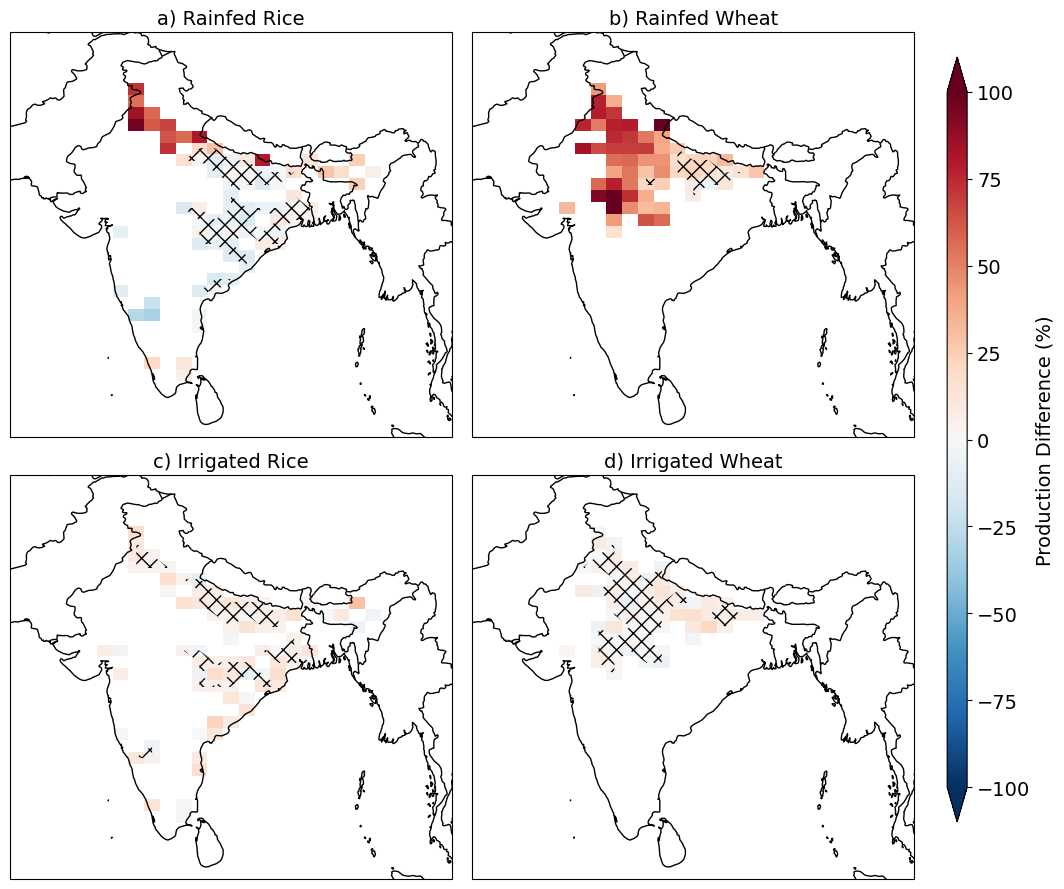

In [13]:
titles = ['a) Rainfed Rice', 'b) Rainfed Wheat', 'c) Irrigated Rice', 'd) Irrigated Wheat']
pvalues = [rice_pvalues, wheat_pvalues, rice_irr_pvalues, wheat_irr_pvalues]
difference = [percent_rice_rain, percent_wheat_rain, percent_rice_irr, percent_wheat_irr]

fig, axes = plt.subplots(2, 2, figsize=(10, 9), subplot_kw={'projection': ccrs.PlateCarree()})
plots = []
for i, ax in enumerate(axes.flatten()):
    
    plot = (difference[i]*100).plot(ax=ax, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-100, vmax=100)
    plots.append(plot)
    # hatch any statistical insignificance (above 5%)
    sig = pvalues[i].where(pvalues[i] > 0.05)
    sig.plot.contourf(ax=ax, hatches=['xx'], colors='none', extend='neither', add_colorbar=False)
    
    ax.set_title(titles[i], fontsize=14, loc='center')
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
    ax.set_extent([65, 100, 5, 37], crs=ccrs.PlateCarree())
    
# Adjust the layout to make space for the colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.08, 0.02, 0.85])  # [left, bottom, width, height]
cbar = fig.colorbar(plots[0], cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick font size
cbar.set_label('Production Difference (%)', fontsize=14)

plt.tight_layout(rect=[0, 0, 0.97, 1])